<a href="https://colab.research.google.com/github/Asgozenko/ML_2025_autumn/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q catboost

import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor

import zipfile
import os



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


Загрузка файлов

In [ ]:
zip_path = "/content/College_Scorecard_Raw_Data_10032025.zip"
extract_path = "/content/scorecard_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)


['MERGED2005_06_PP.csv',
 'MERGED2019_20_PP.csv',
 'FieldOfStudyData1516_1617_PP.csv',
 'FieldOfStudyData1718_1819_PP.csv',
 'MERGED2016_17_PP.csv',
 'FieldOfStudyData1819_1920_PP.csv',
 'MERGED2000_01_PP.csv',
 'MERGED1999_00_PP.csv',
 'MERGED2022_23_PP.csv',
 'MERGED2015_16_PP.csv',
 'MERGED2014_15_PP.csv',
 'MERGED1997_98_PP.csv',
 'MERGED2008_09_PP.csv',
 'MERGED2023_24_PP.csv',
 'MERGED1998_99_PP.csv',
 'MERGED2021_22_PP.csv',
 'Crosswalks',
 'MERGED2004_05_PP.csv',
 'MERGED2011_12_PP.csv',
 '__MACOSX',
 'FieldOfStudyData1415_1516_PP.csv',
 'MERGED2013_14_PP.csv',
 'MERGED2007_08_PP.csv',
 'MERGED2002_03_PP.csv',
 'Most-Recent-Cohorts-Field-of-Study.csv',
 'MERGED2006_07_PP.csv',
 'FieldOfStudyData1617_1718_PP.csv',
 'MERGED2012_13_PP.csv',
 'MERGED2018_19_PP.csv',
 'MERGED1996_97_PP.csv',
 'MERGED2020_21_PP.csv',
 'data.yaml',
 'MERGED2003_04_PP.csv',
 'MERGED2001_02_PP.csv',
 'MERGED2010_11_PP.csv',
 'Most-Recent-Cohorts-Institution.csv',
 'FieldOfStudyData1920_2021_PP.csv',
 'M

Основной датасет

In [ ]:
df = pd.read_csv("/content/scorecard_data/Most-Recent-Cohorts-Institution.csv", low_memory=False)

print(df.shape)
df.head()

(6429, 3306)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,uah.clearcostcalculator.com/student/default/ne...,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,tcc.ruffalonl.com/Alabama State University/Fre...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


Целевая переменная и признаки

In [ ]:
TARGET = 'MD_EARN_WNE_P10' #медианный доход выпускников через 10 лет

numeric_features = [
    'COSTT4_A',
    'DEBT_MDN',
    'SAT_AVG',
    'ADM_RATE',
    'PCTPELL',
    'UGDS']

categorical_features = [
    'CONTROL',
    'LOCALE',
    'REGION']

df_model = df[numeric_features + categorical_features + [TARGET]] #оставляем самое нужное

df_model.head()


,COSTT4_A,DEBT_MDN,SAT_AVG,ADM_RATE,PCTPELL,UGDS,CONTROL,LOCALE,REGION,MD_EARN_WNE_P10
0,23751.0,16600,947.0,0.6622,0.6441,5726.0,1,12.0,5,40628.0
1,27826.0,15832,1251.0,0.8842,0.3318,12118.0,1,12.0,5,54501.0
2,NaN,13385,NaN,NaN,0.6842,226.0,2,12.0,5,37621.0
3,27098.0,13905,1321.0,0.7425,0.2250,6650.0,1,12.0,5,61767.0
4,22028.0,17500,977.0,0.9564,0.7203,3322.0,1,12.0,5,34502.0


Очистка данных

In [ ]:
df_model = df_model.replace('PS', np.nan) #замена пустых значений

#приводим числовые признаки к float
for col in numeric_features + [TARGET]:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

df_model.head()

#удаляем строки без целевой переменной
df_model = df_model.dropna(subset=[TARGET])

print("Размер датасета после очистки:", df_model.shape)

numeric_imputer = SimpleImputer(strategy='median')
df_model[numeric_features] = numeric_imputer.fit_transform(df_model[numeric_features])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df_model[categorical_features] = categorical_imputer.fit_transform(df_model[categorical_features])

df_model.head()

Размер датасета после очистки: (5280, 10)


,COSTT4_A,DEBT_MDN,SAT_AVG,ADM_RATE,PCTPELL,UGDS,CONTROL,LOCALE,REGION,MD_EARN_WNE_P10
0,23751.0,16600.0,947.0,0.6622,0.6441,5726.0,1.0,12.0,5.0,40628.0
1,27826.0,15832.0,1251.0,0.8842,0.3318,12118.0,1.0,12.0,5.0,54501.0
2,24702.0,13385.0,1154.0,0.7781,0.6842,226.0,2.0,12.0,5.0,37621.0
3,27098.0,13905.0,1321.0,0.7425,0.2250,6650.0,1.0,12.0,5.0,61767.0
4,22028.0,17500.0,977.0,0.9564,0.7203,3322.0,1.0,12.0,5.0,34502.0



Gradient Boosting


In [ ]:
# Разделяем признаки и целевую переменную
X = df_model[numeric_features + categorical_features]
y = df_model[TARGET]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

#модель градиентного бустинга
gbr = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42)

#обучение
gbr.fit(X_train, y_train)

#предсказания
y_pred = gbr.predict(X_test)

#метрики качества
print("R²:", round(r2_score(y_test, y_pred), 3))
print("MAE ($):", round(mean_absolute_error(y_test, y_pred), 0))

R²: 0.732
MAE ($): 5560.0


Рейтинг колледжей по ROI

In [ ]:
df_rank = df_model.copy()

# Предсказанный доход
df_rank['PRED_EARN'] = gbr.predict(
    df_rank[numeric_features + categorical_features])

# ROI
df_rank['ROI'] = df_rank['PRED_EARN'] / df_rank['COSTT4_A']

# Убираем экстремальные значения
df_rank = df_rank[df_rank['COSTT4_A'] > 0]

#топ-20 по ROI
top_20 = df_rank.sort_values('ROI', ascending=False).head(20)

# добавляем названия университетов из исходного df
top_20['INSTNM'] = df.loc[top_20.index, 'INSTNM']

top_20[['INSTNM', 'COSTT4_A', 'DEBT_MDN', 'PRED_EARN', 'ROI']]

,INSTNM,COSTT4_A,DEBT_MDN,PRED_EARN,ROI
2202,United States Merchant Marine Academy,9547.0,6500.0,78236.647574,8.194893
3542,Instituto Tecnologico de Puerto Rico-Recinto d...,4274.0,9833.0,24233.652024,5.670017
2244,Cleveland Community College,5477.0,9833.0,30073.300810,5.490835
2492,Ohio University-Eastern Campus,10263.0,15332.0,54500.789016,5.310415
2495,Ohio University-Lancaster Campus,10267.0,15332.0,54198.011097,5.278856
2011,CUNY Bernard M Baruch College,13521.0,10000.0,71033.654455,5.253580
222,Canada College,9514.0,9272.0,49596.973509,5.213052
3906,Carroll Community College,8611.0,7769.0,44766.527141,5.198761
3942,South Texas College,7505.0,9833.0,38788.373171,5.168338
1313,Frederick Community College,8886.0,5500.0,45836.993682,5.158338


## Реализация через Catboost

In [ ]:
# Категориальные признаки в строки
for col in categorical_features:
    df_model[col] = df_model[col].astype(str)

X = df_model[numeric_features + categorical_features]
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_features_idx = [X.columns.get_loc(col) for col in categorical_features]

cat_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='MAE',
    random_seed=42,
    verbose=False
)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_features_idx
)

y_pred_cat = cat_model.predict(X_test)

print("CatBoost R²:", round(r2_score(y_test, y_pred_cat), 3))
print("CatBoost MAE ($):", round(mean_absolute_error(y_test, y_pred_cat), 0))

CatBoost R²: 0.71
CatBoost MAE ($): 5671.0


Сравнение CatBoost и Sklearn

In [ ]:
results = pd.DataFrame({
    "Model": ["HistGradientBoosting", "CatBoost"],
    "MAE": [
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, y_pred_cat)
    ],
    "R2": [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_cat)
    ]
})

results

,Model,MAE,R2
0,HistGradientBoosting,5559.847719,0.731573
1,CatBoost,5671.125719,0.709588


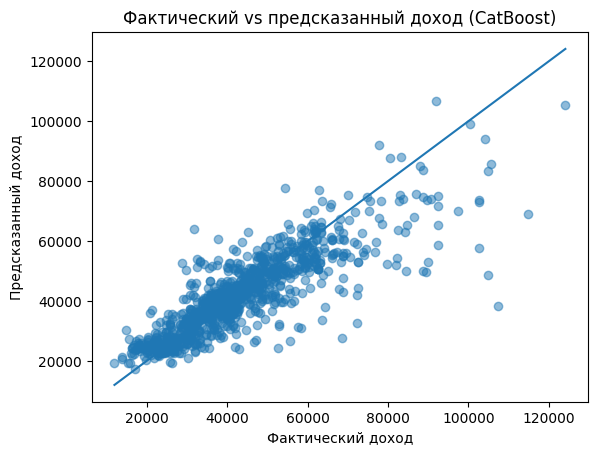

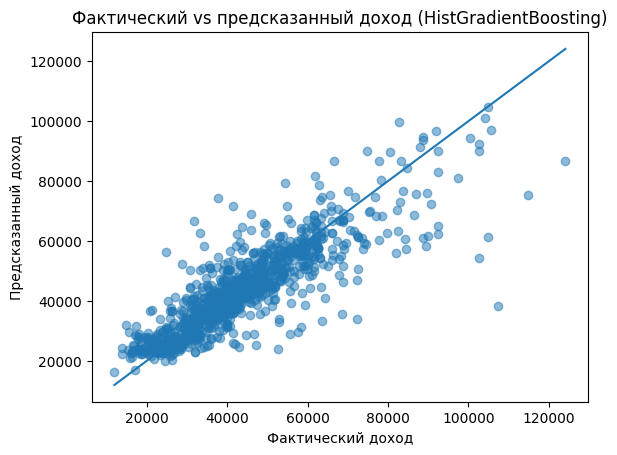

In [ ]:
plt.figure()
plt.scatter(y_test, y_pred_cat, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Фактический доход")
plt.ylabel("Предсказанный доход")
plt.title("Фактический vs предсказанный доход (CatBoost)")
plt.show()

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Фактический доход")
plt.ylabel("Предсказанный доход")
plt.title("Фактический vs предсказанный доход (HistGradientBoosting)")
plt.show()

## Топы

Топ 20

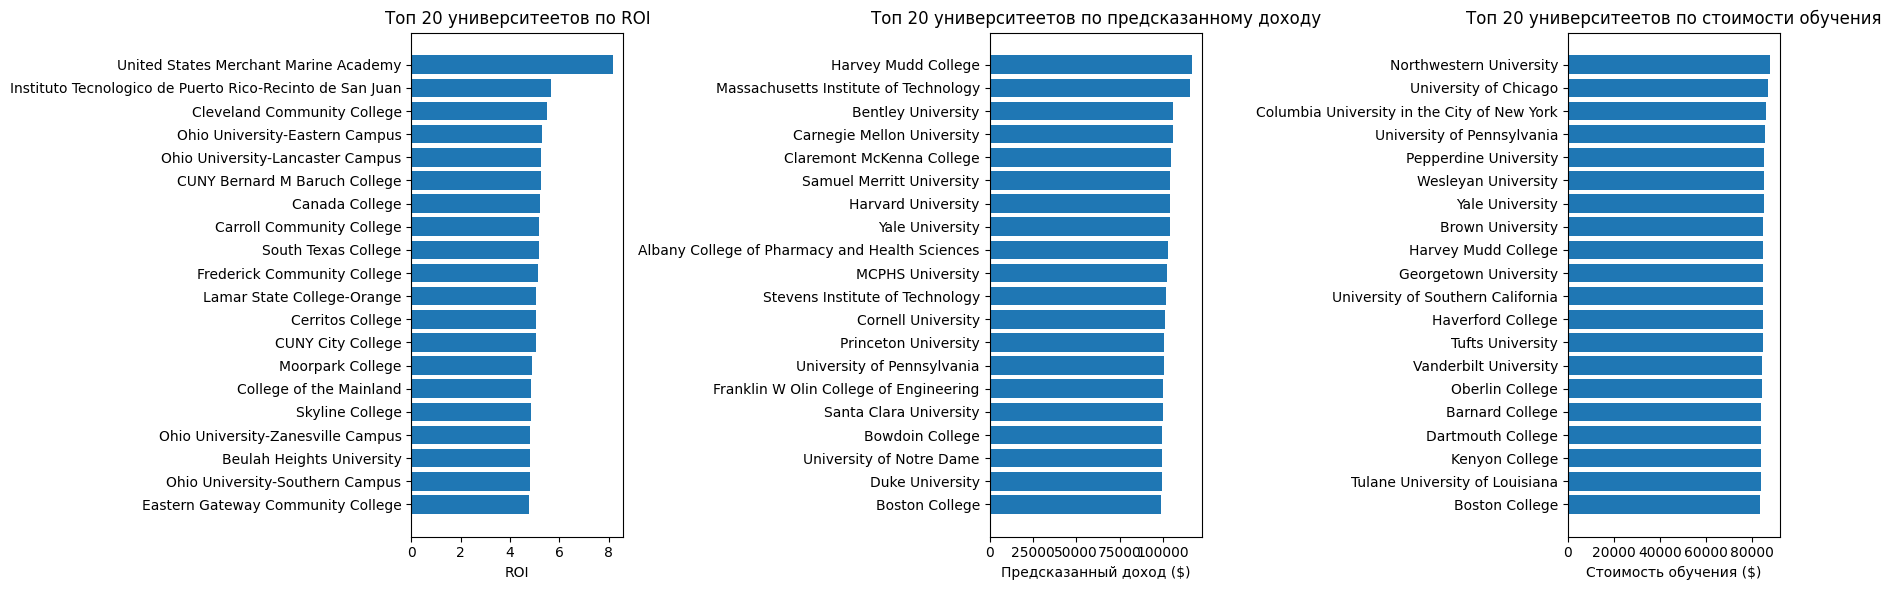

In [ ]:
if 'INSTNM' not in df_rank.columns:
    df_rank['INSTNM'] = df.loc[df_rank.index, 'INSTNM']

top_20_roi = df_rank.sort_values('ROI', ascending=False).head(20)
top_20_income = df_rank.sort_values('PRED_EARN', ascending=False).head(20)
top_20_cost = df_rank.sort_values('COSTT4_A', ascending=False).head(20)

fig, axes = plt.subplots(1,3, figsize=(18,6))

# ROI
axes[0].barh(top_20_roi['INSTNM'], top_20_roi['ROI'])
axes[0].invert_yaxis()
axes[0].set_title("Топ 20 университеетов по ROI")
axes[0].set_xlabel("ROI")

# Предсказанный доход
axes[1].barh(top_20_income['INSTNM'], top_20_income['PRED_EARN'])
axes[1].invert_yaxis()
axes[1].set_title("Топ 20 университеетов по предсказанному доходу")
axes[1].set_xlabel("Предсказанный доход ($)")

# Top Cost
axes[2].barh(top_20_cost['INSTNM'], top_20_cost['COSTT4_A'])
axes[2].invert_yaxis()
axes[2].set_title("Топ 20 университеетов по стоимости обучения")
axes[2].set_xlabel("Стоимость обучения ($)")

plt.tight_layout()
plt.show()


 Кластеризация вузов по ROI и стоимости

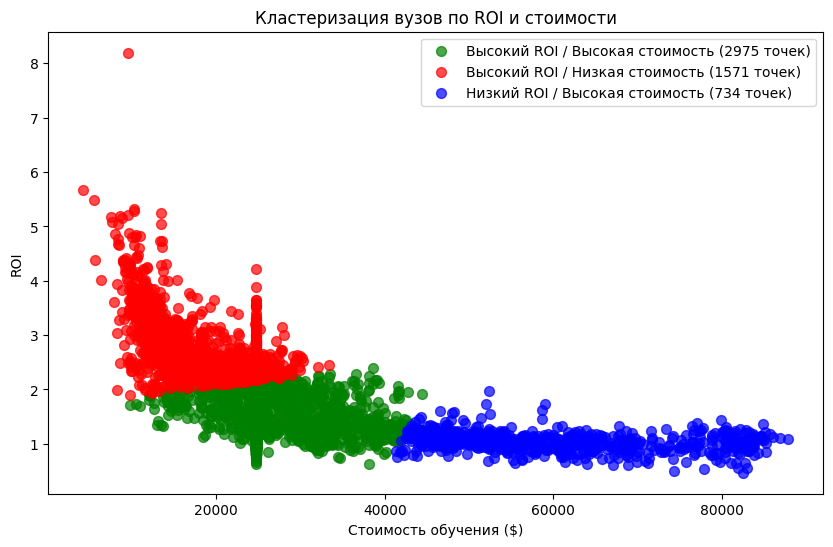

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Берем признаки для кластеризации
cluster_features = df_rank[['ROI', 'COSTT4_A']].copy()

# Масштабирование
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features)

# KMeans с 3 кластерами
kmeans = KMeans(n_clusters=3, random_state=42)
df_rank['cluster'] = kmeans.fit_predict(cluster_scaled)

# Средние значения ROI и COST
cluster_means = df_rank.groupby('cluster')[['ROI','COSTT4_A']].mean()

cluster_names = {}
sorted_clusters = cluster_means.sort_values(['ROI','COSTT4_A'], ascending=[False, True]).index.tolist()

names = ['Высокий ROI / Низкая стоимость',
         'Высокий ROI / Высокая стоимость',
         'Низкий ROI / Высокая стоимость']

for idx, name in zip(sorted_clusters, names):
    cluster_names[idx] = name

df_rank['cluster_name'] = df_rank['cluster'].map(cluster_names)

# Визуализация
color_map_name = {
    'Высокий ROI / Низкая стоимость':'red',
    'Высокий ROI / Высокая стоимость':'green',
    'Низкий ROI / Высокая стоимость':'blue'
}

plt.figure(figsize=(10,6))
for name in df_rank['cluster_name'].unique():
    cluster_data = df_rank[df_rank['cluster_name'] == name]
    plt.scatter(
        cluster_data['COSTT4_A'],
        cluster_data['ROI'],
        alpha=0.7,
        s=50,
        color=color_map_name[name],
        label=f'{name} ({len(cluster_data)} точек)'
    )

plt.xlabel("Стоимость обучения ($)")
plt.ylabel("ROI")
plt.title("Кластеризация вузов по ROI и стоимости")
plt.legend()
plt.show()


Сравнение с медианным предсказанием

In [ ]:
from sklearn.dummy import DummyRegressor

# модель всегда предсказывает медиану целевой переменной
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Метрики
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f"Dummy Regressor (median) -> MAE: {mae_dummy:.0f}, R²: {r2_dummy:.3f}")


Dummy Regressor (median) -> MAE: 12121, R²: -0.023


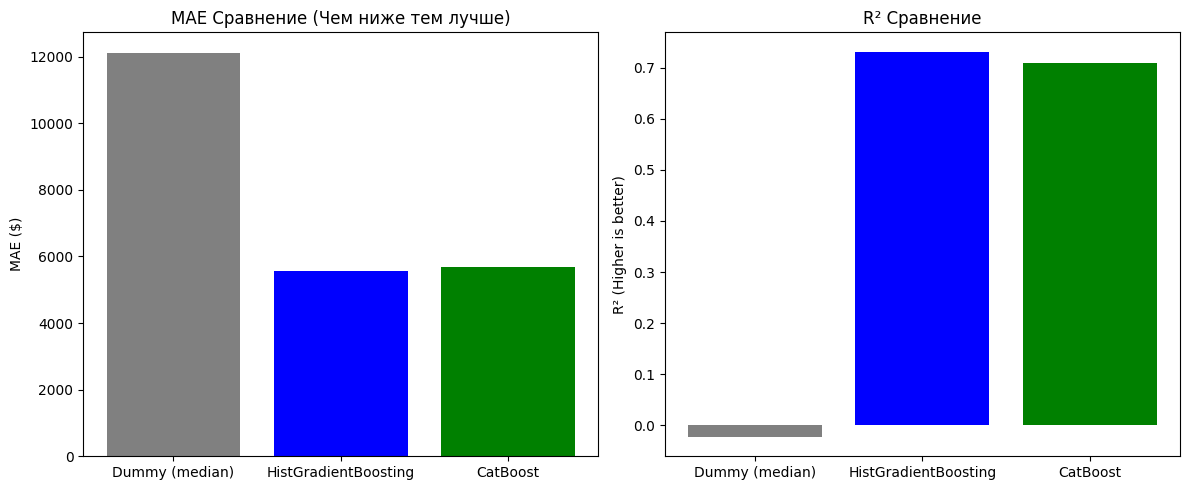

In [ ]:
mae_gbr = mean_absolute_error(y_test, y_pred)
mae_cat = mean_absolute_error(y_test, y_pred_cat)

r2_gbr = r2_score(y_test, y_pred)
r2_cat = r2_score(y_test, y_pred_cat)

# Сравнение
import matplotlib.pyplot as plt

models = ['Dummy (median)', 'HistGradientBoosting', 'CatBoost']
mae_scores = [mae_dummy, mae_gbr, mae_cat]
r2_scores = [r2_dummy, r2_gbr, r2_cat]

plt.figure(figsize=(12,5))

# MAE
plt.subplot(1,2,1)
plt.bar(models, mae_scores, color=['gray','blue','green'])
plt.ylabel("MAE ($)")
plt.title("MAE Сравнение (Чем ниже тем лучше)")

# R²
plt.subplot(1,2,2)
plt.bar(models, r2_scores, color=['gray','blue','green'])
plt.ylabel("R² (Higher is better)")
plt.title("R² Сравнение")

plt.tight_layout()
plt.show()
